In [10]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

In [87]:
train = pd.read_csv('train.csv',parse_dates=['issue_date','listing_date'])

train = train.sample(frac=1).reset_index(drop=True)

#filling the missing the value of condition
train.fillna(3,inplace=True)

In [88]:
train['area_occupied'] = train['height(cm)'] * train['length(m)'] * 100
train['no_of_days'] =abs((train['listing_date'] - train['issue_date']).dt.days)
train['listing_day'] = train['listing_date'].dt.day
train['listing_month'] = train['listing_date'].dt.month
train['listing_dayofweek'] = train['listing_date'].dt.dayofweek
train['listing_weekday'] = train['listing_date'].dt.weekday
train['listing_hour'] = train['listing_date'].dt.hour
train['listing_time'] = train['listing_date'].dt.time

train['issue_day'] = train['issue_date'].dt.day
train['issue_month'] = train['listing_date'].dt.month
train['issue_dayofweek'] = train['listing_date'].dt.dayofweek
train['issue_weekday'] = train['listing_date'].dt.weekday
train['issue_hour'] = train['listing_date'].dt.hour
train['issue_time'] = train['listing_date'].dt.time

train['pet_id'] = train['pet_id'].apply(lambda x: int(x.split('_')[1]))

#get some with pet_id
def id_bins(s):
    if s['pet_id'] <= 63355:
        return 'OLD'
    if s['pet_id'] <= 70150:
        return 'MID'
    else:
        return 'NEW'

train['id_bins'] = train.apply(id_bins,axis=1)

def height_bins(s):
    
    if s['height(cm)'] <=27.36:
        return 'SHORT'
    else:
        return 'TALL'
    
train['height_bin'] = train.apply(height_bins,axis=1)

cat = list(train.select_dtypes('object'))
print('categorical values',cat)
for i in cat:
    l = LabelEncoder()
    l.fit(train[i])
    train[i]= l.transform(train[i])
    
#train = pd.get_dummies(train,
#                          columns=['color_type','id_bins', 'height_bin'],
#                          drop_first=True)

#train.drop(['pet_id'])
print(train.shape)

categorical values ['color_type', 'listing_time', 'issue_time', 'id_bins', 'height_bin']
(18834, 27)


In [89]:
train.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,...,listing_hour,listing_time,issue_day,issue_month,issue_dayofweek,issue_weekday,issue_hour,issue_time,id_bins,height_bin
0,66359,2015-01-16,2017-02-07 09:16:00,2.0,38,0.81,42.33,18,4,0.0,...,9,146,16,2,1,1,9,146,0,1
1,57734,2016-10-09,2017-05-03 18:16:00,0.0,49,0.14,22.41,0,1,1.0,...,18,686,9,5,2,2,18,686,2,0
2,72253,2017-03-20,2017-06-13 18:41:00,0.0,48,0.41,23.77,7,1,1.0,...,18,711,20,6,1,1,18,711,1,0
3,70213,2018-05-16,2018-12-12 12:03:00,1.0,16,0.33,47.91,0,1,0.0,...,12,313,16,12,2,2,12,313,1,1
4,55728,2016-09-21,2016-10-13 11:04:00,2.0,31,0.93,30.02,13,9,0.0,...,11,254,21,10,3,3,11,254,2,1


In [90]:
X = train.drop(['breed_category','pet_category',
                'issue_date','listing_date'],axis=1)
y = train[['breed_category']]
X.shape , y.shape

((18834, 23), (18834, 1))

In [91]:
bestfeatures = SelectKBest(score_func=chi2,k=20)
fit=bestfeatures.fit(X,y)

In [92]:
df1 = pd.DataFrame(fit.scores_)
df2 = pd.DataFrame(X.columns)

df = pd.concat([df1,df2],axis=1)
df.columns = ['specs','score']
df.sort_values(by=['specs'],ascending=False).head(10)

,specs,score
8,475170.943783,no_of_days
14,21001.229052,listing_time
20,21001.229052,issue_time
5,18117.305023,X1
1,8106.168050,condition
0,2152.732013,pet_id
2,1761.062053,color_type
7,1150.005439,area_occupied
6,600.995422,X2
19,154.683066,issue_hour


In [93]:
print(df.nlargest(10,'specs'))

            specs          score
8   475170.943783     no_of_days
14   21001.229052   listing_time
20   21001.229052     issue_time
5    18117.305023             X1
1     8106.168050      condition
0     2152.732013         pet_id
2     1761.062053     color_type
7     1150.005439  area_occupied
6      600.995422             X2
13     154.683066   listing_hour


In [94]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier(random_state=10)
model.fit(X,y)

d= {'columns':X.columns,'importance':model.feature_importances_}
df = pd.DataFrame(data=d)
df.sort_values(by='importance',ascending=False).head(10)

C:\Users\DELL\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DELL\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


,columns,importance
1,condition,0.657730
6,X2,0.025146
5,X1,0.023388
8,no_of_days,0.022123
2,color_type,0.020682
4,height(cm),0.018700
7,area_occupied,0.018674
0,pet_id,0.018637
3,length(m),0.018445
15,issue_day,0.018110


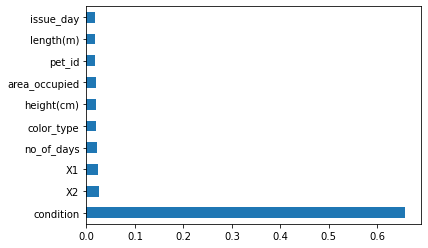

In [95]:
fe = pd.Series(model.feature_importances_,index=X.columns)
fe.nlargest(10).plot(kind='barh')
plt.show()

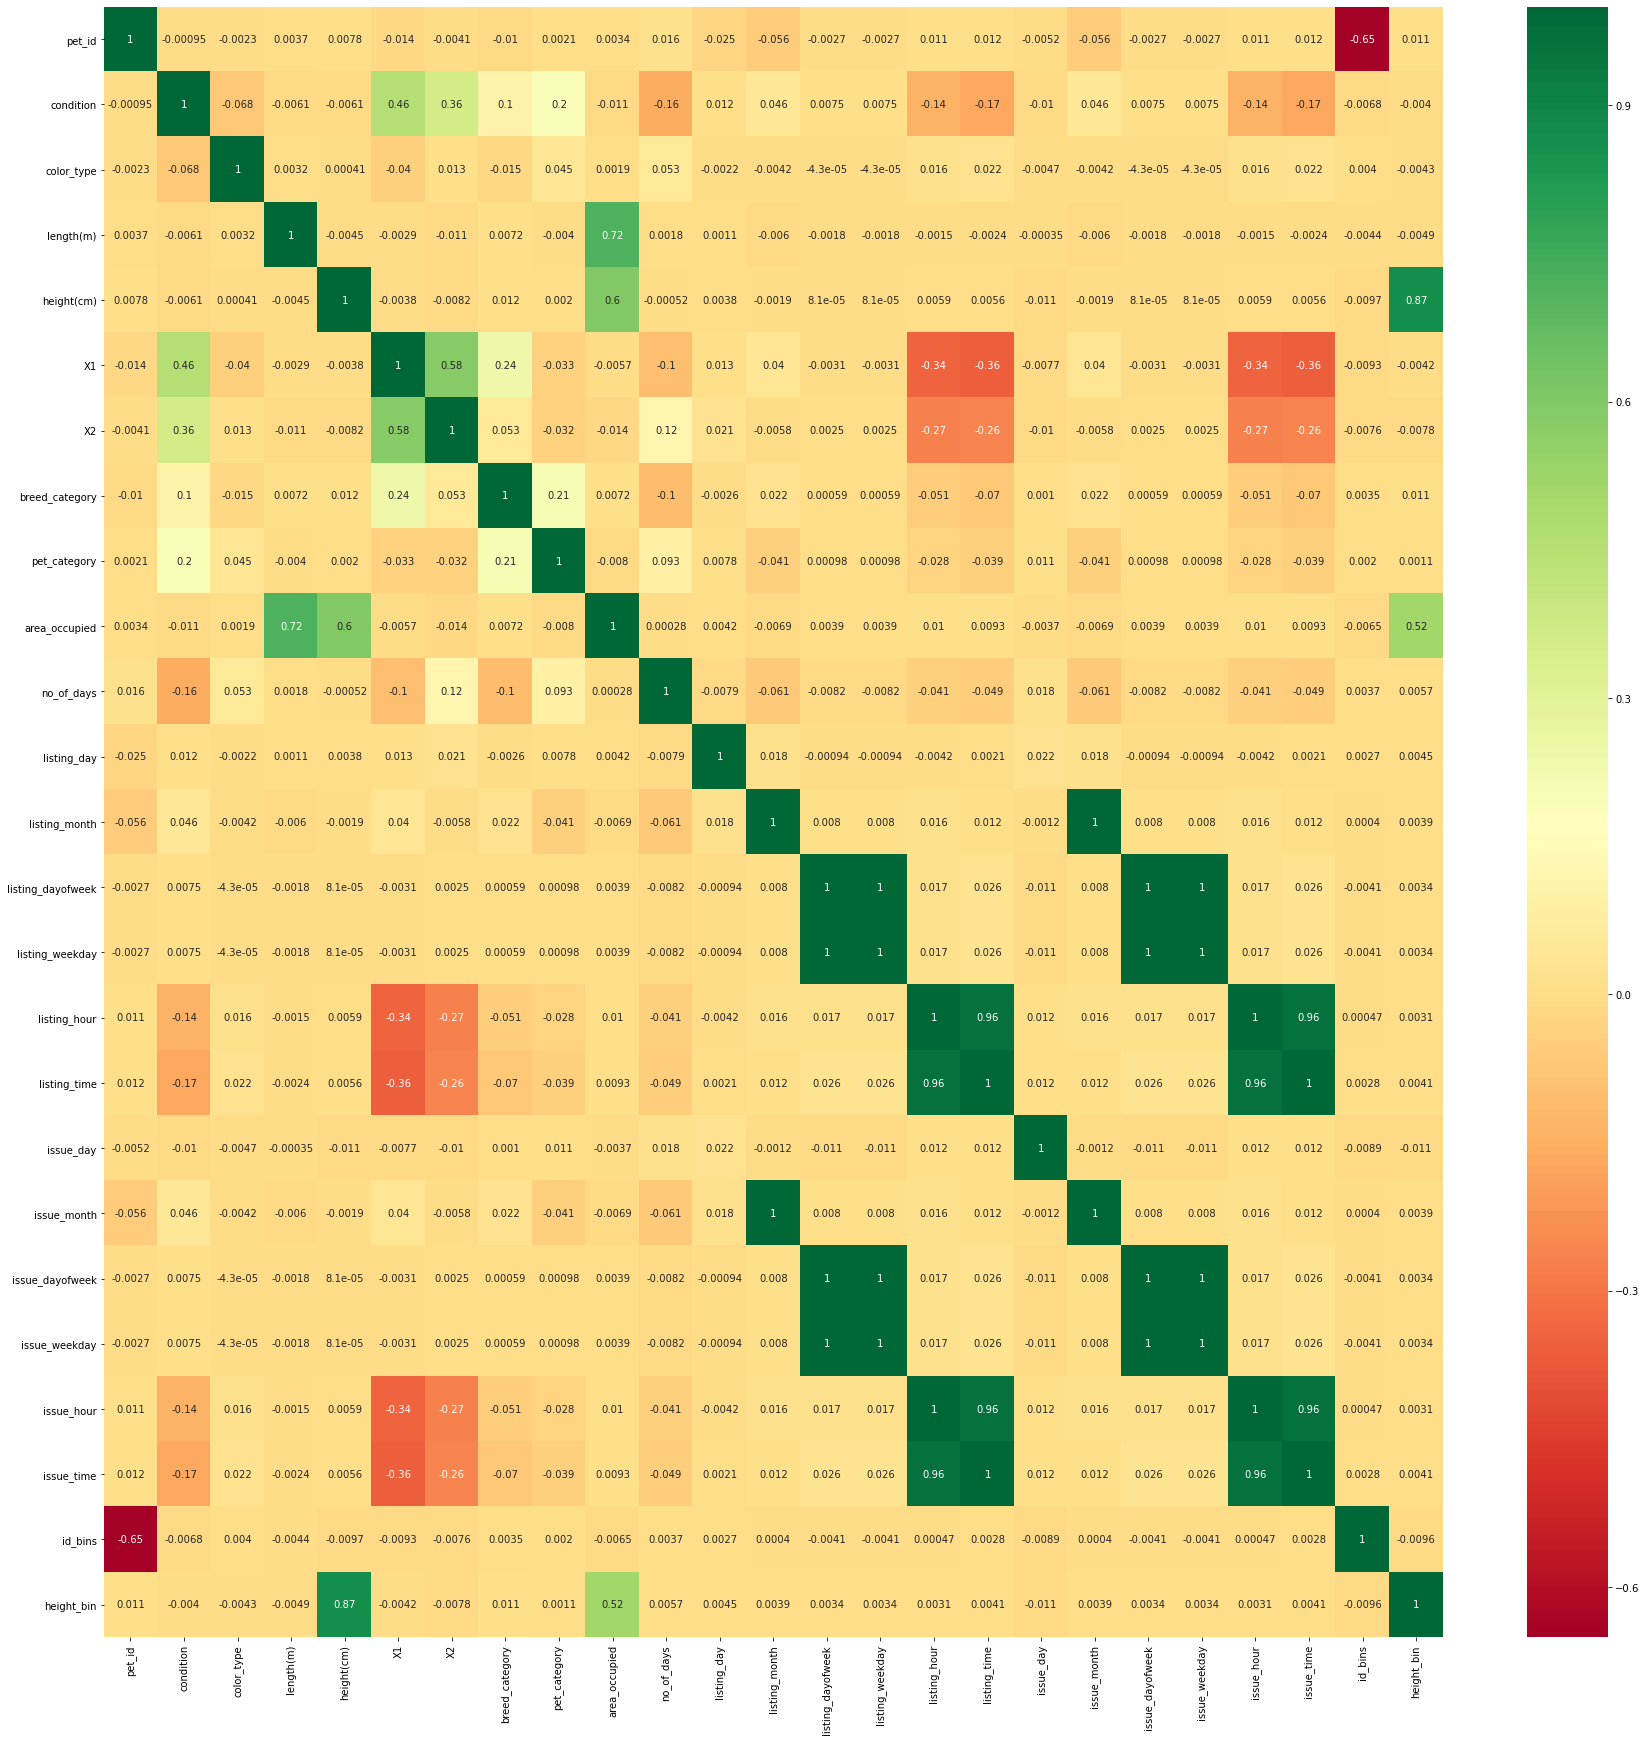

In [97]:
import seaborn as sns
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap='RdYlGn')